In [1]:
using Revise
using SnpArrays
using ElasticArrays
using LinearAlgebra
using Knockoffs
using Statistics
using Plots

┌ Info: Precompiling Knockoffs [878bf26d-0c49-448a-9df5-b057c815d613]
└ @ Base loading.jl:1317


# Try generating Zihuai's knockoffs

Zihuai generates 

$$\hat{X}_j = \hat{\beta_0} + \sum_{k \in B_j}\hat{\beta_k}X_k + \sum_{k \in B_j, k \le j - 1}\hat{\gamma_k}\tilde{X_k}$$

$$\hat{\epsilon} = permute(X_j - \hat{X}_j)$$

$$\tilde{X}_j = \hat{X}_j + \hat{\epsilon}$$

where $B_j$ is a ball of variants near $j$ and $\hat{\beta}_i$ are estimated by least squares. 

In [5]:
x = SnpArray("/Users/biona001/.julia/packages/SnpArrays/n3L4p/data/EUR_subset.bed")
xfloat = convert(Matrix{Float64}, x, center=true, scale=true, impute=true)

379×54051 Matrix{Float64}:
  0.46516   0.163517  0.306468  -0.0298581  …   0.342518   0.163517   0.23281
  0.46516  -6.0338    0.306468  -0.0298581      0.342518   0.163517   0.23281
  0.46516   0.163517  0.306468   1.38467        0.342518   0.163517  -4.17894
  0.46516   0.163517  0.306468  -1.44439        0.342518   0.163517   0.23281
  0.46516   0.163517  0.306468  -1.44439        0.342518   0.163517   0.23281
 -1.91722   0.163517  0.306468   1.38467    …   0.342518   0.163517  -4.17894
 -1.91722   0.163517  0.306468  -0.0298581     -2.7483     0.163517   0.23281
 -1.91722   0.163517  0.306468   1.38467        0.342518   0.163517   0.23281
  0.46516   0.163517  0.306468  -1.44439        0.342518   0.163517   0.23281
 -1.91722   0.163517  0.306468  -0.0298581      0.342518   0.163517   0.23281
  0.46516   0.163517  0.306468  -0.0298581  …  -2.7483     0.163517   0.23281
  0.46516   0.163517  0.306468  -0.0298581      0.342518   0.163517  -4.17894
  0.46516  -6.0338    0.306468  -0.02

In [38]:
@time X̃ = full_knockoffscreen(x)

Making KnockoffScreen knockoffs...100%|█| Time: 0:02:50


170.337890 seconds (44.51 M allocations: 87.454 GiB, 5.28% gc time)


379×54051 Matrix{Float64}:
  0.351641   0.147835   -0.134619    …   0.23828     0.628525    0.634757
  0.373569  -5.60451     0.289859        0.433562    0.630873    0.164404
  0.662003   0.764331    0.256667        0.247003    0.528647   -3.88177
 -0.389703   0.301167    0.306468        0.379656    1.32231    -1.60329
  0.464063  -0.298659    0.37047         0.40034    -0.0236692  -0.203174
 -2.21275    0.598387    0.0161963   …   0.570781    0.590276   -3.92047
 -1.76151   -0.0305947  -0.00686096     -2.95595    -0.433438    0.814615
 -1.8798    -0.143889   -0.596669        0.442858   -0.291123    0.332455
  0.46516    0.142947    0.380121        0.301167    0.0256244   0.613507
 -2.46513    0.214152    0.960342        0.314345    0.204084    0.45527
  0.51432   -0.393085    0.541795    …  -2.80079     0.265278    0.572208
  0.607831   0.23445     0.170886        0.0768846   0.651356   -4.63031
  0.626044  -5.79566     0.273274        0.335382    0.0985899   0.777343
  ⋮             

## Knockoff statistics

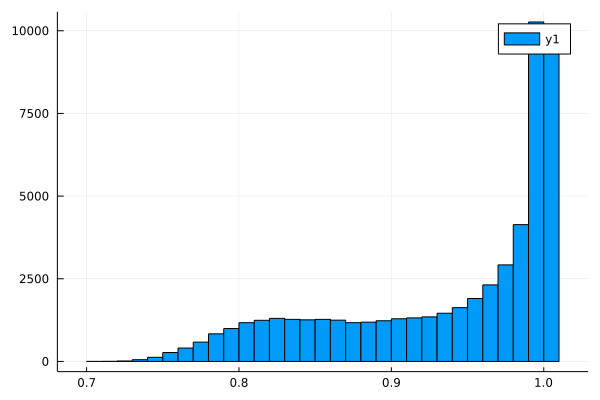

In [45]:
n, p = size(x)
r2, snp1 = sizehint!(Float64[], p), zeros(n)
for i in 1:p
    push!(r2, abs(cor(@view(xfloat[:, i]), @view(X̃[:, i]))))
end
histogram(r2)

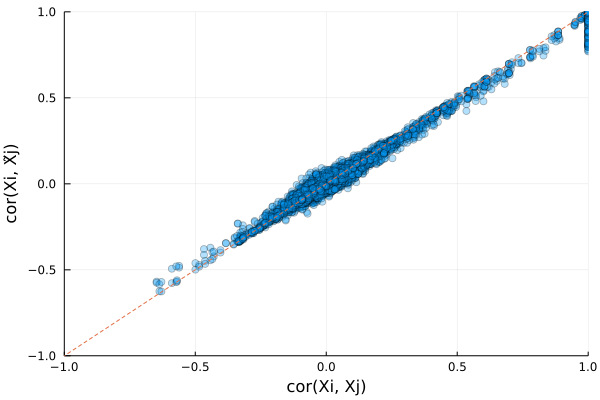

In [48]:
# compare cor(X[i], X[j]) and cor(X[i], X̃[j])
n, p = size(xfloat)
r1, r2, snp1, snp2 = Float64[], Float64[], zeros(n), zeros(n)
for i in 1:100, j in 1:100
    push!(r1, cor(@view(xfloat[:, i]), @view(xfloat[:, j])))
    push!(r2, cor(@view(xfloat[:, i]), @view(X̃[:, j])))
end
scatter(r1, r2, alpha=0.3, xlim=(-1, 1), ylim=(-1, 1), 
    xlabel = "cor(Xi, Xj)", ylabel="cor(Xi, X̃j)")
Plots.abline!(1, 0, line=:dash, legend=false)

## Efficient QR factor update

Generating knockoff for variable $j$ requires solving a least squares problem where number of covariates change with $j$. Since least squares is solved internally by QR factorization, we may be able to exploit [clever strategies to update the Q and R factor](http://eprints.ma.man.ac.uk/1192/1/qrupdating_12nov08.pdf), which will significantly improve performance. 


## Future Design

Because $\tilde{X}$ is continuous, saving the full knockoffs matrix is only feasible for small $n$ and $p$. For large problems we need to have an iterator format

```julia
xdata = SnpArray("plinkfile.bed")
x = zeros(size(x, 1))
x̃ = zeros(size(x, 1))
for j in size(x, 2)
    copyto!(x, @view(xdata[:, i]), center=true, scale=true)
    generate_knockoff!(x̃, x)
    
    # do something with x and x̃...
end
```




In [13]:
using ElasticArrays, LinearAlgebra
X = ElasticArray{Float64}(undef, 10, 10)
X .= rand(10, 10)
y = rand(10)
β = zeros(10)
X \ y

10-element Vector{Float64}:
  0.1961738429707722
 -0.08223896374453044
 -0.7827830074297127
  0.4115074449815227
  0.16249351031603948
  0.7046945053118326
  0.553917022304253
  0.7854169072271069
 -0.631002527220376
 -0.4705221902700406